# 誤差逆伝播法：Zipser-Andersenモデルを例にして

https://link.springer.com/article/10.1007/s11023-017-9443-4/figures/5

Zipser-Andersenモデル。 a 3層構造のネットワークで、2組の入力ユニットは網膜性位置細胞（左下）と眼球運動細胞（右下）を表す。隠れユニットは、第3グループのPPC細胞の行動をモデル化したものである。出力層のユニット（2つのバージョン）は、頭頂部の位置をエンコードする細胞を表しています。b 領域7aの視覚ニューロンの受容野は、焦点付近に単一のピークを持つ。 c 領域7aの目の位置を表す30個のユニットを合成し、その発火率を眼球の水平・垂直方向のずれの関数としてプロットしたもの。

> The influence of the angle of gaze upon the excitability of the light- sensitive neurons of the posterior parietal cortex


スポットサイズを$w$とする．$1/e$の代わりに$1/2$とすれば半値全幅(FWHM)となる．$G(X+w/2)=G/e$より，$\sigma=\frac{\sqrt{2}w}{4}$

-40度から傾き正あるいは負．0度をピークとして減少あるいは上昇の4種類ある．今回は１次関数で記述可能なものを採用．

The monotonic format units have firing rates that are a linear function of position of the stimulus in head-centred coordinates

### Setup

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter

### NN modelの実装

In [2]:
sigmoid(x) = 1 / (1 + exp(-x))

sigmoid (generic function with 1 method)

In [3]:
@kwdef mutable struct NN{FT}
    n_batch::UInt32 # batch size
    n_in::UInt32 # number of input units
    n_hid::UInt32 # number of hidden units
    n_out::UInt32 # number of output units
    
    # weights
    # Xavier Weight Initialization
    W1::Array{FT} = 2(rand(n_in, n_hid) .- 0.5) / sqrt(n_in)
    W2::Array{FT} = 2(rand(n_hid, n_out) .- 0.5) / sqrt(n_hid)
    b1::Array{FT} = zeros(1, n_hid)
    b2::Array{FT} = zeros(1, n_out)
end

順伝播(feedforward propagation)
$$
\begin{align}
\text{入力層 : }&\mathbf{z}^{(0)}=\mathbf{x}\\
\text{隠れ層 : }&\mathbf{z}^{(\ell)}=f\left(\mathbf{a}^{(\ell)}\right)\\
&\mathbf{a}^{(\ell+1)}=W^{(\ell+1)}\mathbf{z}^{(\ell)}+\mathbf{b}^{(\ell+1)}\\
\text{出力層 : }&\hat{\mathbf{y}}=\mathbf{z}^{(L)}
\end{align}
$$

逆伝播(backward propagation)
$$
\begin{align}
\text{目的関数 : }&\mathcal{L}=\frac{1}{2}\left\|\hat{\mathbf{y}}-\mathbf{y}\right\|^{2}\\
\text{最急降下法 : }&\Delta W^{(\ell)}=-\eta \frac{\partial \mathcal{L}}{\partial W^{(\ell)}}\\
&\Delta \mathbf{b}^{(\ell)}=-\eta \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(\ell)}}\\
\text{誤差逆伝播法 : }&\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}}=\hat{\mathbf{y}}-\mathbf{y}\\
&\delta^{(L)}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}} \frac{\partial \mathbf{z}^{(L)}}{\partial \mathbf{a}^{(L)}}=\left(\hat{\mathbf{y}}-\mathbf{y}\right) \odot f^{\prime}\left(\mathbf{a}^{(L)}\right)\\
&\mathbf{\delta}^{(\ell)}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(\ell)}} \frac{\partial \mathbf{z}^{(\ell)}}{\partial \mathbf{a}^{(\ell)}}=\left(W^{(\ell+1)}\right)^\top \delta^{(\ell+1)} \odot f^{\prime}\left(\mathbf{a}^{(\ell)}\right)\\
&\frac{\partial \mathcal{L}}{\partial W^{(\ell)}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(\ell)}} \frac{\partial \mathbf{z}^{(\ell)}}{\partial \mathbf{a}^{(\ell)}} \frac{\partial \mathbf{a}^{(\ell)}}{\partial W^{(\ell)}}=\delta^{(\ell)}\left(\mathbf{z}^{(\ell-1)}\right)^\top\\
&\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(\ell)}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(\ell)}} \frac{\partial \mathbf{z}^{(\ell)}}{\partial \mathbf{a}^{(\ell)}} \frac{\partial \mathbf{a}^{(\ell)}}{\partial \mathbf{b}^{(\ell)}}=\delta^{(\ell)}
\end{align}
$$

バッチ処理を考慮すると，行列を乗ずる順番が変わる．

In [167]:
function update!(variable::NN, η, x::Array, y::Array, training::Bool) #, memory)
    @unpack n_batch, n_in, n_hid, n_out, W1, W2, b1, b2 = variable 
    # feedforward
    h = sigmoid.(x * W1 .+ b1) # hidden
    ŷ = sigmoid.(h * W2 .+ b2) # output
    error = ŷ - y
    
    if training 
        # backward
        # d/dx sigmoid(x) = sigmoid(x) * (1 - sigmoid(x))
        # cross entropy error
        δ2 = error #.* ŷ .* (1.0 .- ŷ)
        δ1 = δ2 * W2' .* h .* (1.0 .- h)

        # update weights and bias
        η̄ = η/ n_batch
        W1[:, :] -= η̄ * x' * δ1
        W2[:, :] -= η̄ * h' * δ2
        b1[:, :] -= η̄ * sum(δ1, dims=1)
        b2[:, :] -= η̄ * sum(δ2, dims=1)
        """
        Adam_update_weights(W1, x' * δ1/ n_batch, memory)
        Adam_update_weights(W2, h' * δ2/ n_batch, memory)
        Adam_update_weights(b1, sum(δ1, dims=1)/ n_batch, memory)
        Adam_update_weights(b2, sum(δ2, dims=1)/ n_batch, memory)
        """
    end
    return error, ŷ, h
end

update! (generic function with 2 methods)

### datasetの作成

In [5]:
# Gaussian mask s
function GaussianMask(pos; sizex=8, sizey=8, σ=1)
    x = 0:sizex-1
    y = 0:sizey-1
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    
    x0, y0 = pos
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0*(σ^2)))
    return mask ./ sum(mask)
end

GaussianMask (generic function with 1 method)

ガウシアンのピークから1/eに減弱するのが15度．10度間隔で8x8．左右：-40度から40度

入力は64+32=96ユニット

### 学習

In [77]:
# dataset parameter
θmax = 40.0 # degree, θ∈[-θmax, θmax]
Δθ = 10.0 # degree
stimuli_size = Int(2θmax / Δθ)
w = 15.0 # degree; 1/e width
σ = √2w/(4Δθ);

# model parameter
n_in = stimuli_size^2 + 2 #96    # number of inputs 64 + 32
n_hid = 16   # number of hidden units
n_out = stimuli_size^2   # number of outputs
η = 1e-2  # learning rate

# training parameter
n_data = 10000
n_batch = 20 # batch size
n_iter_per_epoch = Int(n_data/n_batch)
n_epoch = 1000 # number of epoch

データセットの生成．

In [164]:
retinal_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
head_centered_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
eye_pos = head_centered_pos - retinal_pos; # ∈ [-80, 80]

# convert
input_retina = [hcat(GaussianMask((retinal_pos[i, :] .+ θmax)/Δθ, sizex=stimuli_size, sizey=stimuli_size, σ=σ)...) for i in 1:n_data];
input_retina = vcat(input_retina...)
eye_pos /= 2θmax;
#eye_pos_encoded = hcat([vcat(vcat([eye_pos_coding.(eye_pos[i, :]; linear_param=pos_slope_param), eye_pos_coding.(-eye_pos[1, :]; linear_param=pos_slope_param)]...)...) for i in 1:n_data]...)';

# concat
x_data = hcat(input_retina, eye_pos) #_encoded)
y_data = vcat([hcat(GaussianMask((head_centered_pos[i, :] .+ θmax)/Δθ, sizex=stimuli_size, sizey=stimuli_size, σ=σ)...) for i in 1:n_data]...);

モデルの定義

In [165]:
nn = NN{Float32}(n_batch=n_batch, n_in=n_in, n_hid=n_hid, n_out=n_out);
#memory = Adam_memory{Float32}();

In [168]:
error_arr = zeros(Float32, n_epoch); # memory array of each epoch error

@showprogress "Training..." for e in 1:n_epoch
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x = x_data[idx, :]
        y = y_data[idx, :]
        
        error, _, _ = update!(nn, η, x, y, true) #, memory)
        error_arr[e] += sum(error .^ 2)
    end 
    error_arr[e] /= n_data
end

Training...100%|████████████████████████████████████████| Time: 0:00:40


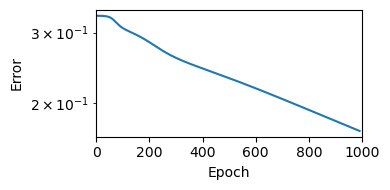

In [169]:
figure(figsize=(4,2))
semilogy(error_arr[10:end])
ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

In [170]:
x = x_data[1:2, :]
y = y_data[1:2, :]

error, ŷ, h = update!(nn, η, x, y, false);

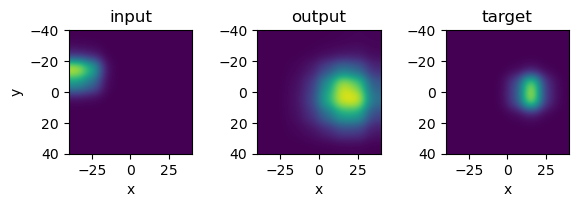

In [171]:
id = 2
figure(figsize=(6,2))
ax1 = subplot(1,3,1)
title("input")
ax1.imshow(reshape(x[id, 1:64], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax1.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x"); ylabel("y");

ax2 = subplot(1,3,2)
title("output")
ax2.imshow(reshape(ŷ[id, :], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax2.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x");

ax3 = subplot(1,3,3)
title("target")
ax3.imshow(reshape(y[id, :], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax3.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x");

tight_layout()

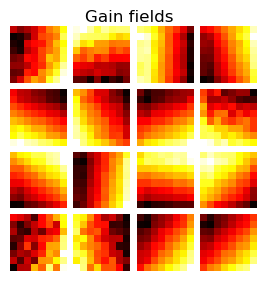

In [172]:
# Plot Receptive fields
figure(figsize=(3.2, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:n_hid
    subplot(4, 4, i)
    imshow(reshape(nn.W1[1:stimuli_size^2, i], (stimuli_size, stimuli_size)), cmap="hot") #, interpolation="gaussian")
    axis("off")
end
suptitle("Gain fields", fontsize=12)
subplots_adjust(top=0.925)

> A back-propagation programmed network that simulates response properties of a subset of posterior parietal neurons

https://www.nature.com/articles/331679a0

a, 領域7aのモデル化に用いたバックプロパゲーションネットワーク。視覚入力は、1eの幅が15度のガウス型受容野を持つ64個のユニットで構成されています。各受容野の中心は、10度間隔の8×8配列の位置を占めている。陰影はシングルスポット刺激に対する活動レベルを表しており、陰影が濃いほど活動率が高いことを示している。各ユニットは、説明のために局所的に配列されていますが、各隠れユニットは64個の網膜入力ユニットのすべてから入力を受けるので、このパターンはモデルの一側面ではありません。視線位置の入力は、水平方向の位置をコードする2セット（負の傾きに対応するものと正の傾きに対応するもの）と垂直方向の位置をコードする2セットの8ユニットからなる4セットで構成されています。濃淡は活動のレベルを表しています。境界線は説明のためだけに並べられており、隠れた層で利用可能な情報を表すものではない。各眼球位置セルは、隠れ層のすべてのユニットに投影される。右がガウス型、左がモノトニック型の2つの出力形式を使用した。ガウシアン形式のユニットは、ガウシアンシェーディングされた受容野を頭部中心の座標にプロットしたものです。1eの幅は15度で、頭部座標空間の8×8の配列を中心に、10度の間隔で配置されています。単調なフォーマットのユニットは、頭の中心座標における刺激の位置の線形関数である発火率を持っています。頭部を中心とした垂直方向の位置には2セット、水平方向の位置には2セット、それぞれ逆の傾きを持つ8個のユニットが4セット用意されています。ここでも濃淡は活動の度合いを表しており、地形的な順序は説明のためだけのものである。また、Wを含む小さなボックスは、逆伝播によって重みが学習されるシナプスの位置を示している。各隠れユニットは、出力層のすべてのセルに投影される。隠れたユニットと出力層のユニットの出力活動はロジスティック関数によって計算される： output= 1 ( 1 + e-""'), ここで net= (入力の加重和) +bias. 接続の矢印は活動の伝播の方向を示しており，エラーは逆方向に伝播していく． バックプロパゲーション法は、多次元のシナプス重み空間において誤差の勾配降下を実施することにより、シナプス重みの変更が常にネットワークを低誤差に向かわせることを保証する。

https://www.vis.caltech.edu/documents/9416/neural_networks.pdf
https://www.frontiersin.org/articles/10.3389/fnint.2015.00072/full

私たちは、3層構造のネットワーク（図4）を使用しました。このネットワークは、任意の眼球と網膜の位置のペアが与えられたときに、視覚ターゲットを頭部中心の座標にマッピングするように訓練されています。第1層（入力層）には、視覚刺激を表すユニットの配列と、眼球位置を表すユニットのセットの2つのセクションがあります。第2層は、入力を出力にマッピングする隠れユニットで構成されています。各隠れユニットは、すべての入力ユニットからの入力を受け、第3出力層のすべてのユニットに投影します。

隠れ層と出力層の各ユニットの出力は、入力のシナプス強度加重和にバイアス項を加えたS字型（ロジスティック）関数として計算されます。 学習パラダイムは逆伝搬学習を用いており、入力と所望の出力を選択し、入力をネットワークの第1層に適用し、それが生み出す活動をネットワークを通して出力ユニットに伝搬させる。その後、実際の出力が希望の出力から差し引かれ、エラーが生成されます。この誤差を利用して，出力層ユニットと隠れ層ユニットのシナプスの重みを，逆伝播の手順で調整する。トレーニングは、すべてのウェイトをランダムにした状態で開始されるため、誤差が大きくなり、その誤差が望ましいレベルになるまでトレーニングサイクルを繰り返すことになる。

ネットワークへの網膜の位置と眼球の位置の入力は，視覚刺激のみと眼球の位置のみに反応する後頭頂皮質の細胞の特性を用いてモデル化した．視覚入力は、1eの幅が15度、各ピークが10度離れた64個のガウス型の受容野が8×8の配列で構成されていた。視線位置の入力は、8個のユニットが4セットあり、水平方向と垂直方向の視線位置の正負の傾きをそれぞれ1セットずつ持ちます。 出力層では、頭部を中心とした座標で位置を表す2つの表現を用いた。1つ（図4aの出力2）は、網膜入力の表現と同様に、各ユニットがガウス型の受容野を持つガウス形式で、位置を網膜座標ではなく頭の中心座標でコーディングしたものです。もう1つ（図4aの出力1）は単調なフォーマットで、各ニューロンの活動は、頭の中心座標における刺激の位置の線形関数となります。ガウシアン形式では、網膜の入力配列と同様の64ユニットの配列を用い、モノトニック形式では、眼球位置の入力配列と同様の32ユニットの配列を用いました。ガウシアン形式とモノトニック形式が選ばれたのは、脳細胞のコーディング形式として最も一般的なものだからです。また，モノトニック形式は，入力の眼球位置コードと同じ表現になるという興味深い特徴がある。このため，動物が視覚刺激をフェーブした場合，結果として得られる眼球位置信号は，刺激の正しい位置を頭部中心の座標で示す教師として使用することができる。

モデルネットワークは，ランダムに選択された入力眼球位置と網膜位置のペアを用いて学習されました。出力ユニットの学習に用いた教師信号（所望の出力）は，入力によって暗示される頭部を中心とした座標における真の空間位置であり，単調またはガウス形式で表された．ネットワークの学習は早く、1,000回の試行で、網膜ユニットの中心間の距離に相当する精度に達した。トレーニングを続けると、誤差は減少し続けたが、その割合は低くなった。

Eye positionは8 x 4set．

視線位置の入力は、水平方向の位置をコーディングする2セット（負の傾きに対応するものと正の傾きに対応するもの）と垂直方向の位置をコーディングする2セット、それぞれ8ユニットの4セットで構成されています。濃淡は活動のレベルを表す。境界線は説明のためだけに並べられており、隠れた層で利用可能な情報を表すものではない。各眼球位置セルは、隠れ層のすべてのユニットに投影される。右側がガウス型、左側が単調型の2種類の出力形式を使用した。ガウシアン形式のユニットには、ガウシアンシェーディングされた受容野が頭部中心の座標にプロットされています。

出力型にはgaussian output 形式（右）とmonotonic format（左）がある．

### old functions

In [ ]:
dsigmoid(x) = sigmoid(x) * (1 - sigmoid(x)) # derivative of sigmoid 

In [ ]:
relu(x) = x .* (x .> 0)
get_line(p1, p2) = [(p2[2]-p1[2])/(p2[1]-p1[1]), (p2[1]*p1[2] - p1[1]*p2[2])/(p2[1]-p1[1])] # [slope, intercept]
eye_pos_coding(x; linear_param) = relu(linear_param[1, :] * x .+ linear_param[2, :])

N = 8
x = -80:1:80
p2y = range(0, 2.0, length=N) # y of 2nd point
pos_slope_param = hcat([get_line([80, 1], [-80, -p2y[i]]) for i in 1:N]...)
#neg_slope_param = hcat([get_line([-40, 1], [40, -p2y[i]]) for i in 1:N]...)
y_pos = hcat(eye_pos_coding.(x; linear_param=pos_slope_param)...)
#y_neg = eye_pos_coding.(x; linear_param=neg_slope_param);

eye_pos_encoded = eye_pos_coding(-10; linear_param=pos_slope_param)
imshow(eye_pos_encoded[:, :]')

figure(figsize=(4,2))
plot(x, y_pos')
xlabel("Eye position"); ylabel("Firing rate")
tight_layout()

In [ ]:
retinal_pos = (rand(2) .- 0.5) * 2θmax # ∈ [-40, 40]
head_centered_pos = (rand(2) .- 0.5) * 2θmax # ∈ [-40, 40]
eye_pos = head_centered_pos - retinal_pos; # ∈ [-80, 80]

In [ ]:
input_retina = GaussianMask((retinal_pos .+ θmax)/Δθ, sizex=stimuli_size, sizey=stimuli_size, σ=2) #√2w/(4Δθ))
figure(figsize=(2,2))
imshow(input_retina) #, interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
tight_layout()

### optimizer

In [ ]:
# to Adam optimizer
@kwdef mutable struct Adam_memory{FT}
    ms = Dict()
    vs = Dict()
end

# Adam optimizer
function Adam_update_weights(param, grad, memory::Adam_memory; α=0.01, β1=0.9, β2=0.999, eps=1e-8)
    @unpack ms, vs = memory
    key = objectid(param)
    if !haskey(ms, key) 
        ms[key] = zeros(size(param))
        vs[key] = zeros(size(param))
    end
    
    m, v = ms[key], vs[key]

    m += (1 - β1) * (grad - m)
    v += (1 - β2) * (grad .* grad - v)
    param[:, :] -= α * m ./ (sqrt.(v) .+ eps)
end